# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [3]:
# for local version (comment out if on colab)
! unzip -qq ./hseds-texts-2020.zip -d hseds-texts-2020

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! unzip -qq /content/drive/MyDrive/hseds-texts-2020.zip -d hseds-texts-2020

replace hseds-texts-2020/sample_submission(1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'

In [5]:
import numpy as np

In [6]:
import pandas as pd

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [8]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

[nltk_data] Downloading package punkt to /Users/ivan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [58]:
df['common'] = df['negative'] + df['positive']

In [59]:
df['common']

0        [there, were, issues, with, the, wifi, connect...
1                         [tv, not, working, no, positive]
2        [more, pillows, beautiful, room, great, locati...
3                               [very, business, location]
4        [rooms, could, do, with, a, bit, of, a, refurb...
                               ...                        
99995    [no, coffee, facilities, in, room, air, con, d...
99996    [the, room, was, far, too, hot, on, the, first...
99997    [terrible, worn, out, mattress, dust, behind, ...
99998    [no, negative, very, profissional, and, nice, ...
99999    [no, negative, great, breakfast, and, the, roo...
Name: common, Length: 100000, dtype: object

In [60]:
# check for empty strings and values and remove empty ones (where both positive and negative reviews don't exists) because they are useless
df = df[df['common'].astype(bool)]

In [61]:
df.shape

(99993, 5)

In [62]:
X = df['common'].to_numpy()
y = df['score'].to_numpy()

In [63]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18122020)

In [64]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(69995,) (29998,)
(69995,) (29998,)


### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [65]:
from sklearn.metrics import mean_absolute_error

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [67]:
def identity_tokenizer(text):
    return text

In [68]:
tfidf = TfidfVectorizer(min_df=0.001, max_df=1.0, tokenizer=identity_tokenizer, lowercase=False)

In [69]:
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [70]:
print(tfidf_train.shape, tfidf_test.shape)

(69995, 1981) (29998, 1981)


In [71]:
%%time
linreg = LinearRegression()
linreg.fit(tfidf_train, y_train)
y_pred = linreg.predict(tfidf_test)

CPU times: user 1.15 s, sys: 927 ms, total: 2.08 s
Wall time: 1.09 s


In [72]:
print(mean_absolute_error(y_pred, y_test))
assert(mean_absolute_error(y_pred, y_test) < 1.0)

0.896265582729089


### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [73]:
from gensim.models import Word2Vec

In [401]:
tfidf_full = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
tfidf_full.fit_transform(X)

<99993x34728 sparse matrix of type '<class 'numpy.float64'>'
	with 2727997 stored elements in Compressed Sparse Row format>

In [406]:
idf_dict = dict(zip(tfidf_full.get_feature_names(), tfidf_full.idf_))
print(len(idf_dict))

34728


In [204]:
w2v = Word2Vec(X, size=300, sg=0)

In [388]:
w2v.wv.most_similar('bathroom')

[('toilet', 0.7184092998504639),
 ('bathtub', 0.6816843152046204),
 ('bath', 0.663115382194519),
 ('bathrooms', 0.6529030799865723),
 ('carpet', 0.607327938079834),
 ('bedroom', 0.6070654988288879),
 ('wardrobe', 0.5917820334434509),
 ('shower', 0.5753301382064819),
 ('washroom', 0.5735063552856445),
 ('closet', 0.5713695287704468)]

In [459]:
X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X, y, test_size=0.3, random_state=18122020)

In [460]:
print(X_w2v_train.shape, X_w2v_test.shape, y_w2v_train.shape, y_w2v_test.shape)

(69995,) (29998,) (69995,) (29998,)


In [485]:
def average_w2v(w2v, document, k=300, use_idf=False, gen_embedding=False):
  np.random.seed(20122020)
  weights = []
  document = [word for word in document if word in w2v.wv.vocab]
  
  if not document:
    if gen_embedding:
      return np.random.rand(k)

  if len(document) == 1:
    return w2v[document[0]]

  if use_idf:
    weights = np.array([idf_dict[word] for word in document if word in w2v.wv.vocab])
    assert(len(weights) == len(document))
    weights = weights.reshape(-1, 1)
    result = w2v[document] * weights
    assert(result.shape == w2v[document].shape)
    result = np.sum(result, axis=0)
    return result

  return np.mean(w2v[document], axis=0)

In [486]:
def GetSentenceEmbedding(w2v_dict, array: np.array, k=300, use_idf=False, gen_embedding=False):
  new = []
  invalid_indices = []
  for i in range(len(array)):
    try:
      tmp = average_w2v(w2v_dict, array[i], k, use_idf=use_idf, gen_embedding=gen_embedding)
      assert(len(tmp) == k)
      new.append(tmp)
    except ValueError as ve: # for non existing embeddings
      invalid_indices.append(i)
  return np.stack(np.array(new), axis=0), invalid_indices

In [487]:
w2v_train, inv_idx_train = GetSentenceEmbedding(w2v, X_w2v_train, gen_embedding=True)
w2v_test, inv_idx_test = GetSentenceEmbedding(w2v, X_w2v_test, gen_embedding=True)
y_w2v_train = np.delete(y_w2v_train, inv_idx_train)
y_w2v_test = np.delete(y_w2v_test, inv_idx_test)
print(len(w2v_train), len(y_w2v_train))
print(len(w2v_test), len(y_w2v_test))
assert(len(w2v_train) == len(y_w2v_train))
assert(len(w2v_test) == len(y_w2v_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


69995 69995
29998 29998


In [488]:
assert(w2v_train.shape[1] == 300 and w2v_test.shape[1] == 300)

In [489]:
print(w2v_train.shape, w2v_test.shape)

(69995, 300) (29998, 300)


In [490]:
%%time 
lr_w2v = LinearRegression()
lr_w2v.fit(w2v_train, y_w2v_train)
y_w2v_pred = lr_w2v.predict(w2v_test)

CPU times: user 2.53 s, sys: 198 ms, total: 2.73 s
Wall time: 1.55 s


In [491]:
print(mean_absolute_error(y_w2v_pred, y_w2v_test))
assert(mean_absolute_error(y_w2v_pred, y_w2v_test) < 1.0)

1.0039407353812055


AssertionError: ignored

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [492]:
def calc_idf(texts):
    pass

In [493]:
w2v_train_idf, inv_idx_train = GetSentenceEmbedding(w2v, X_w2v_train, use_idf=True, gen_embedding=True)
w2v_test_idf, inv_idx_test = GetSentenceEmbedding(w2v, X_w2v_test, use_idf=True, gen_embedding=True)
y_w2v_train = np.delete(y_w2v_train, inv_idx_train)
y_w2v_test = np.delete(y_w2v_test, inv_idx_test)
print(len(w2v_train_idf), len(y_w2v_train))
print(len(w2v_test_idf), len(y_w2v_test))
assert(len(w2v_train_idf) == len(y_w2v_train))
assert(len(w2v_test_idf) == len(y_w2v_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


69995 69995
29998 29998


In [494]:
assert(w2v_train.shape[1] == 300 and w2v_test.shape[1] == 300)

In [495]:
lr_w2v.fit(w2v_train_idf, y_w2v_train)
y_w2v_idf_pred = lr_w2v.predict(w2v_test_idf)

In [496]:
print(mean_absolute_error(y_w2v_idf_pred, y_w2v_test))
assert(mean_absolute_error(y_w2v_idf_pred, y_w2v_test) < 1.0)

0.9609069507579878


Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:

In [497]:
import matplotlib.pyplot as plt
%matplotlib inline

In [498]:
e_sizes = [50, 100, 200, 300, 400, 500, 1000]

In [501]:
def Train(e_sizes: list, seed: int=18122020, gen_embedding=False, use_idf=False):
  mae_results = []
  np.random.seed(seed)
  for k in e_sizes:
    print("Case: k = %d" % k)
    print("Training Word2Vec embeddings...")
    w2v = Word2Vec(X, size=k, sg=0)
    print("Finished Training\n")
    X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    print("Getting Sentence Embeddings...")
    w2v_train, inv_idx_train = GetSentenceEmbedding(w2v, X_w2v_train, k=k, use_idf=use_idf, gen_embedding=gen_embedding)
    w2v_test, inv_idx_test = GetSentenceEmbedding(w2v, X_w2v_test, k=k, use_idf=use_idf, gen_embedding=gen_embedding)
    y_w2v_train = np.delete(y_w2v_train, inv_idx_train)
    y_w2v_test = np.delete(y_w2v_test, inv_idx_test)
    assert(len(w2v_train) == len(y_w2v_train))
    assert(len(w2v_test) == len(y_w2v_test))
    assert(w2v_train.shape[1] == k and w2v_test.shape[1] == k)
    print("Finished Getting Sentence Embeddings\n")

    print("Performing Linear Regression")
    lr_w2v = LinearRegression()
    lr_w2v.fit(w2v_train, y_w2v_train)
    y_w2v_pred = lr_w2v.predict(w2v_test)
    print("k = %d, mae: %.8f" % (k, mean_absolute_error(y_w2v_pred, y_w2v_test)))

    mae_results.append(mean_absolute_error(y_w2v_pred, y_w2v_test))
    print("Finished training for k = %d\nMoving On...\n\n" % k)
  return mae_results

In [502]:
mae_results = Train(e_sizes, gen_embedding=True, use_idf=True)

Case: k = 50
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 50, mae: 1.04612926
Finished training for k = 50
Moving On...


Case: k = 100
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 100, mae: 1.01438485
Finished training for k = 100
Moving On...


Case: k = 200
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 200, mae: 0.97755621
Finished training for k = 200
Moving On...


Case: k = 300
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 300, mae: 0.95675447
Finished training for k = 300
Moving On...


Case: k = 400
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 400, mae: 0.95050623
Finished training for k = 400
Moving On...


Case: k = 500
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 500, mae: 0.94293663
Finished training for k = 500
Moving On...


Case: k = 1000
Training Word2Vec embeddings...
Finished Training

Getting Sentence Embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Finished Getting Sentence Embeddings

Performing Linear Regression
k = 1000, mae: 0.92898357
Finished training for k = 1000
Moving On...




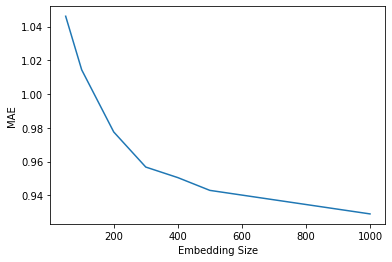

In [503]:
plt.plot(e_sizes, mae_results)
plt.xlabel("Embedding Size")
plt.ylabel("MAE")
plt.show()

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.


In [506]:
from gensim.models import FastText

In [531]:
ft = FastText(X, size=300, min_n=3, max_n=8, seed=18122020, iter=20)
X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(X, y, test_size=0.3, random_state=18122020)

In [537]:
def average_ft(ft, document):
  np.random.seed(20122020)
  weights = []
  document = [word for word in document if word in ft.wv.vocab]

  if not document:
    return np.zeros(300)

  if len(document) == 1:
    return ft[document[0]]


  return np.mean(ft[document], axis=0)

In [538]:
def FTGetSentenceEmbedding(ft, array):
  new = []
  invalid_indices = []
  for i in range(len(array)):
      tmp = average_ft(ft, array[i])
      assert(len(tmp) == 300)
      new.append(tmp)
  return np.stack(np.array(new), axis=0)

In [539]:
ft_train = FTGetSentenceEmbedding(ft, X_ft_train)
ft_test = FTGetSentenceEmbedding(ft, X_ft_test)
print(len(ft_train), len(y_ft_train))
print(len(ft_test), len(y_ft_test))
assert(len(ft_train) == len(y_ft_train))
assert(len(ft_test) == len(y_ft_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


69995 69995
29998 29998


In [540]:
lr_ft = LinearRegression()
lr_ft.fit(ft_train, y_ft_train)
y_pred_ft = lr_ft.predict(ft_test)

In [541]:
print(mean_absolute_error(y_pred_ft, y_ft_test))
assert(mean_absolute_error(y_pred_ft, y_ft_test) < 1.0)

0.9988481218912844


#### Выводы:


### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [17]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

In [18]:
import torch
from torch import nn
from torch.nn import functional as F

In [19]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [20]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [21]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))

In [22]:
MAX_LEN

399

In [23]:
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
                           batch_first=True)

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        ## TODO
        pass
        
    def __len__(self):
        ## TODO
        pass
    
    def __getitem__(self, idx):
        ## TODO
        pass

In [ ]:
BATCH_SIZE = 1

train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_EPOCHS = 1

for n in range(NUM_EPOCHS):
    model.train()
    ## TODO

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.